## CAR Model for crash prediction
### Developed by: bpben

In [28]:
import re
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import describe

In [29]:
import json

In [30]:
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as tt
import theano.sparse
import scipy.sparse

### Data processing
The approach here is to create 3 time-lag features:

1. crashes in the past week
2. crashes in the past month
3. crashes in the past quarter (three months)
4. average crashes per week up to target week

All features except 4 are calculated to exclude one another.  That is, crashes in the past month does not include the past week's crashes.  Crashes in the past quarter do not include the past month.

In [31]:
SEG_CHARS = ['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']

In [32]:
# Read in data
data = pd.read_csv('../data/processed/vz_predict_dataset.csv.gz', 
                   compression='gzip', dtype={'segment_id':'str'})
data.sort_values(['segment_id', 'year','week'], inplace=True)

In [33]:
# get segments with non-zero crashes
data_nonzero = data.set_index('segment_id').loc[data.groupby('segment_id').crash.sum()>0]
data_nonzero.reset_index(inplace=True)

In [34]:
def format_crash_data(data, col, target_week, target_year):
    """ formats crash data for train/test 
    target_week: week to predict (make into binary target)
    target_year: year for predicted week
    note: data must be available for 4 months prior to target
    gets previous week count, previous month count, previous quarter count, avg per week
    """
    assert target_week>16
    pre_week = target_week - 1
    pre_month = range(pre_week-4, target_week)
    pre_quarter = range(pre_month[0]-12, target_week)
    
    # week interval for each segment
    # full range = pre_quarter : target
    sliced = data.loc[(slice(None),slice(target_year,target_year), slice(1, target_week)),:]
    week_data = sliced[col].unstack(2)
    week_data.reset_index(level=1, inplace=True)
    
    # aggregate
    week_data['pre_month'] = week_data[pre_month].sum(axis=1)
    week_data['pre_quarter'] = week_data[pre_quarter].sum(axis=1)
    week_data['pre_week'] = week_data[pre_week]

    # avg as of target week
    except_target = data.loc[(slice(None),
                       slice(target_year,target_year),
                       slice(target_week,None)),:].index
    avg_week = data.drop(except_target)
    avg_week = avg_week.reset_index().groupby('segment_id')[col].mean()
    avg_week.name = 'avg_week'
    # join to week data
    week_data = week_data.join(avg_week)

    # binarize target
    week_data['target'] = (week_data[target_week]>0).astype(int)
    week_data = week_data.reset_index()

    return(week_data[['segment_id','target', 'pre_week',
                      'pre_month', 'pre_quarter', 'avg_week']])

In [35]:
crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', 19, 2017)

In [36]:
#data_segs = data_nonzero.groupby('segment_id')[SEG_CHARS].max()
data_segs = data.groupby('segment_id')[SEG_CHARS].max()
data_segs.reset_index(inplace=True)
# add crash lags to segments
data_model = crash_lags.merge(data_segs, on='segment_id')

In [37]:
# read in adj
adj = pd.read_csv('../data/processed/adjacency_info.csv', dtype={'segment_id':'str'})
# only include adj that are in data model
adj = adj[adj.segment_id.isin(data_model.segment_id)]
# create adj matrix (1 if is adjacent, 0 otherwise)
adj_mat = adj.merge(adj, on='orig_id')
adj_mat = adj_mat.drop(['orig_id'], axis=1)
adj_mat = pd.concat([adj_mat.segment_id_x, pd.get_dummies(adj_mat.segment_id_y)], axis=1)
adj_mat = adj_mat.groupby('segment_id_x').max()
adj_mat = adj_mat.apply(lambda x: x.astype(float))
# fill diagonal (self) with zero
np.fill_diagonal(adj_mat.values, 10**-6)
adj_mat.index.name = 'segment_id'

In [38]:
# add adjacency to maintain order
data_model = data_model.merge(adj_mat, left_on='segment_id', 
                              right_index=True, how='left')
amat = data_model[data_model.segment_id.unique()].values

In [60]:
# create features for model
N = len(data_model) # number of observations
data_model['speed_g30'] = (data_model.SPEEDLIMIT>30).astype(int)
data_model['intersection'] = data_model.segment_id.apply(lambda x: x[:2]!='00').astype(int)

## working CAR class and model

In [62]:
class CAR(pm.distributions.distribution.Continuous):
    def __init__(self, alpha, adjacency, *args, **kwargs):
        if not isinstance(adjacency, np.ndarray):
            raise ValueError("Adjacency matrix is not an ndarray.")
        n, m = adjacency.shape
        if n != m or np.any(adjacency != adjacency.T):
            raise ValueError('Adjacency matrix must be symmetric.')
        if 'shape' in kwargs and kwargs['shape'] == n:
            raise ValueError('Invalid shape: Must match matrix dimension.')
        kwargs['shape'] = n
        super(CAR, self).__init__(*args, **kwargs)
        self.n = n
        self.alpha = tt.as_tensor_variable(alpha)
        adjacency_sparse = scipy.sparse.csr_matrix(adjacency)
        self.adjacency = theano.sparse.as_sparse_variable(adjacency_sparse)
        self.neighbors = tt.as_tensor_variable(adjacency.sum(0))
        self.mean = tt.zeros(n)
        self.median = self.mean
        adj = adjacency.astype('d').copy()
        sqrt_neighbors = 1 / np.sqrt(adjacency.sum(0))
        adj[:] *= sqrt_neighbors[:, None]
        adj[:] *= sqrt_neighbors[None, :]
        self.eigs = scipy.linalg.eigvalsh(adj)

    def logp(self, x):
        Wx = theano.sparse.dot(self.adjacency, x.reshape((self.n, 1)))
        tau_dot_x = self.neighbors * x - self.alpha * Wx.ravel()
        logdet = tt.log(1 - self.alpha * self.eigs).sum()
        logp = 0.5 * (logdet - tt.dot(x, tau_dot_x))
        return logp

with pm.Model() as model:
    b0 = pm.Normal('intercept', mu=0, sd=1)
    b1 = pm.Normal('avg_week', mu=0, sd=1)
    b2 = pm.Normal('speed_limit_g30', mu=0, sd=1)
    #b3 = pm.Normal('intersection', mu=0, sd=1)

    # random effect precision parameter
    sd = pm.HalfCauchy('sd', beta=2)
    # strength of spatial correlation
    alpha = pm.Uniform('alpha', lower=-1, upper=1)
    phi = CAR('mu_phi', alpha=alpha, adjacency=amat)
    
    theta = pm.invlogit(b0 + b1 * data_model.avg_week.values + \
                        b2 * data_model.speed_g30.values + sd * phi)# + \
                        #b3 * data_model.intersection.values)
    
    obs_crash = pm.Binomial('obs_crash', n=N, p=theta, 
                            observed=data_model.target.values)
    
    trace = pm.sample(5000, tune=1500, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 7,073: 100%|██████████| 200000/200000 [05:25<00:00, 614.00it/s]     
Finished [100%]: Average ELBO = 7,128.9
100%|██████████| 5000/5000 [23:35<00:00,  4.73it/s]   


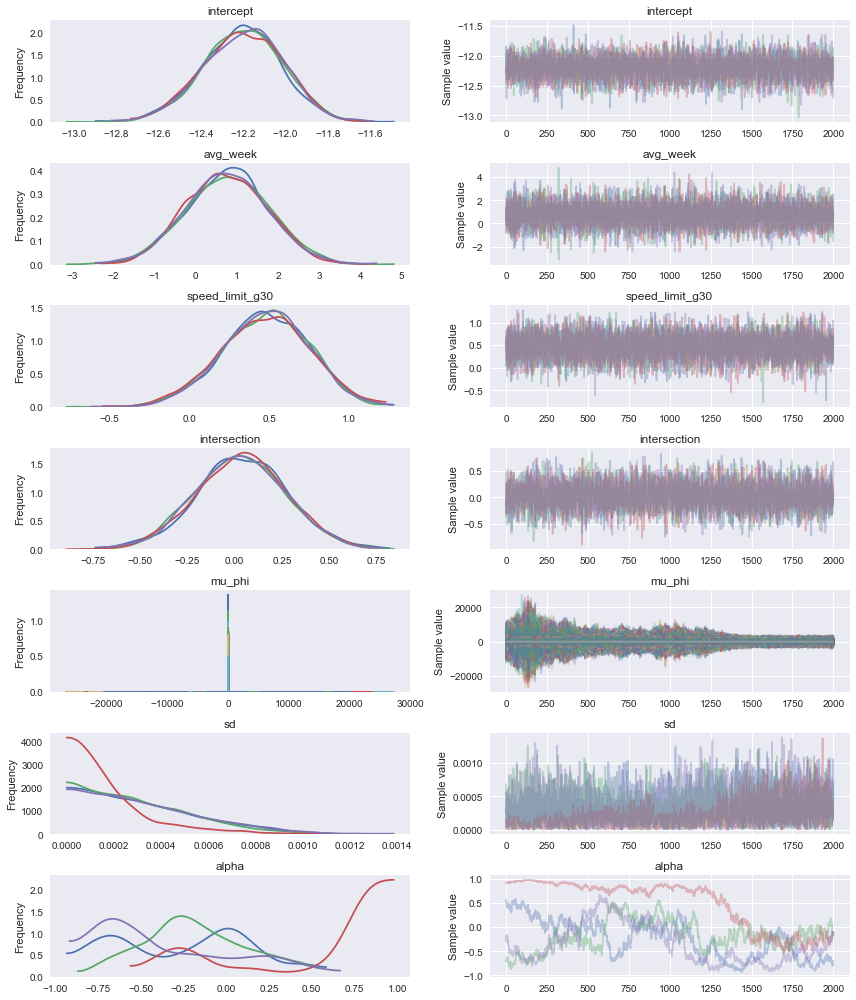

In [72]:
pm.traceplot(trace[3000:]);

In [64]:
from sklearn.metrics import roc_auc_score

In [77]:
ppc = pm.sample_ppc(trace[4000:], model=model, samples=5000)

100%|██████████| 5000/5000 [00:44<00:00, 113.35it/s]


In [78]:
pred_y = np.mean(ppc['obs_crash'], axis=0)

In [79]:
# convert target to binary
O_int = (O>0).astype(int)
roc_auc_score(O_int, pred_y)

0.5521461986704238

In [71]:
#MAE
print "MAE is : {}".format(
    np.mean(abs(pred_y - O_int))
)

MAE is : 0.0354550029603


In [ ]:
combined = road_make(inters_fp, non_inters_fp)

In [ ]:
# run 53 times, for each week
preds_all = data_model['segment_id'].values.reshape(-1,1)
for i in range(54):
    print 'run ' + str(i)
    ppc = pm.sample_ppc(trace[1500:], model=model, samples=5000)
    pred_y = np.mean(ppc['obs_crash'], axis=0).reshape(-1,1)
    preds_all = np.concatenate([preds_all, pred_y], axis=1)

In [ ]:
# week predictions
preds_all_df = pd.DataFrame(preds_all)
preds_all_df.columns = ['segment_id'] + range(54)
preds_all_df.to_csv('../data/processed/car_preds_weekly.csv')
#pd.DataFrame(zip(data_model['segment_id'].values, pred_y),
#            columns=['segment_id', 'pred']).to_csv('../data/processed/car_preds.csv')

In [ ]:
# output predicted probabilities
pd.DataFrame(zip(data_model['segment_id'].values, pred_y),
            columns=['segment_id', 'pred']).to_csv('../data/processed/car_preds.csv')